In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook
from tqdm.autonotebook import tqdm

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/2299671418.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"


In [3]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [4]:
MPLHEP = False
if MPLHEP:
    import mplhep as hep
    plt.style.use(hep.style.CMS)

In [41]:
sys.path.append("../../nuclearpy_models")
from models.BE import dz_be, semf_be
from models.BE import dz_be, semf_be, sr_be, sr_fast_be
sr_be = lambda z, n: sr_fast_be(z, n)[0] #! Fast version WARNING

from utils.metrics import RegressionMetrics

In [42]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [43]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>=12").drop_duplicates(subset=['Z', 'N']).query("Z<50")
exp_df["A"] = exp_df["Z"] + exp_df["N"]
exp_df = exp_df.query("Z <= 50")

In [44]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["sr_pred"] = (exp_df.progress_apply(lambda x: sr_be(x["Z"], x["N"]), axis=1))
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]


  0%|          | 0/1249 [00:00<?, ?it/s]

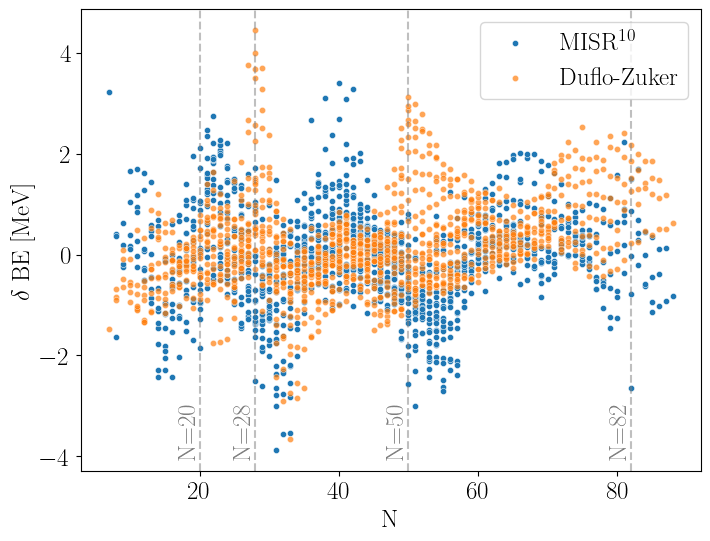

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=exp_df, x="N", y="sr_error", label=r"MISR$^{10}$", s=20)
sns.scatterplot(data=exp_df, x="N", y="dz_error", label="Duflo-Zuker", alpha=0.7, s=20)

# Labels for scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set(xlabel="N", ylabel=r"$\delta$ BE [MeV]")
# hlines on the magic numbers
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax.axvline(i, color="grey", linestyle="--", alpha=0.5)
    # Add vertical text to each line
    ax.text(i, -3.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
plt.savefig("./plots/sr_dz_error.pdf", bbox_inches="tight")

#### Loading test

In [46]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames


used_dfs = [
    "DD-ME2",
    # "SKMS",
    "HFB24",
    "NL3S",
    "UNEDF1",
]

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]

In [47]:
th_datastes

['DD-ME2', 'HFB24', 'NL3S', 'UNEDF1']

In [48]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12 and N>=12").query("(N+Z)<250") for th_dataste in th_datastes}

In [49]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_semf(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    # foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    # foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_in_exp[df_name] = foo.dropna()


# Regression Metrics

In [50]:
exp_df = exp_df.query("Z >= 12").query("Z<=50")

In [51]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["sr_pred"], "sr")()
results = pd.concat([semf_metrics, dz_metrics, dz_sr_metrics], axis=0)

for df_name in used_dfs:
   res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
   results = pd.concat([results, res], axis=0)
all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})

sr_rmse = results.reset_index().query("index == 'sr'")["RMSE"].values[0]
dz_rmse = results.reset_index().query("index == 'DZ'")["RMSE"].values[0]

In [52]:
results[["MAE", "RMSE"]]

,MAE,RMSE
SEMF,3.547973,5.091692
DZ,0.640284,0.892970
sr,0.761686,0.999584
DD-ME2,2.584362,2.915745
HFB24,0.555177,0.737793
NL3S,2.058411,2.557418
UNEDF1,1.954330,2.342975


In [53]:
# 0.769106	0.998873

In [54]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = df.query(f"Z=={fixed_z}")
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="Duflo Zuker", color="black", alpha=0.5)
    plt.errorbar(foo_df["N"], foo_df["BE"], yerr=foo_df["uBE"], fmt="o", label="Experiment", color="black")
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"]
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label=None, color="black")
    for i, (model, name) in enumerate(zip(models, model_names)):
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        if isinstance(preds_in[0], (list, np.ndarray)):
            preds_in = [x[0] for x in preds_in]
        print(preds_in)
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")

    ax.set(xlabel="N", ylabel=r"$\delta(BE)$ [MeV]", xlim=(n_min, n_max), ylim=(-10, 10))
    # put the legend in the left down corner
    ax.legend(fontsize=14)
    # Add annotations inside good looking boxes
    ax.annotate(f"Z={fixed_z}", xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    ax.legend(fontsize=14)
    plt.savefig(f"BE_{fixed_z}.pdf", bbox_inches="tight")

[219.69175315 241.46398998 259.60555194 278.93548746 294.8807743
 312.32831445 326.28033643 341.1181944  351.8138497  363.538711
 372.00962335 382.40349787 389.87109636 399.18274734 405.42806345
 413.49209341 418.54577343 425.50682411 429.54104137 435.5565853
 438.7056973  443.88860252 446.25066119 450.68890199 452.34583557
 456.11666282 457.14188491 460.31468475 460.77359814 460.77359814
 463.4096918  463.35969153 465.51274728 465.00400457 466.72101096
 465.79752018 467.11980044 465.82033142 466.78440321 465.14327631
 465.78153615 463.82922906 464.17048007 461.93408628 462.00392586
 459.50747742 459.32855241 456.59320951]


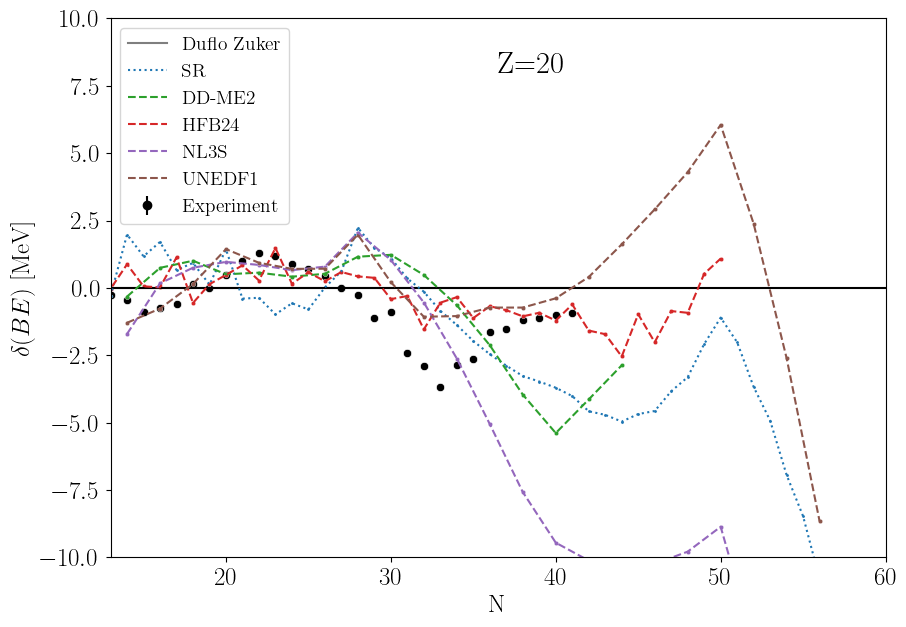

In [55]:
plot_isotope_be(exp_df, models=[sr_be],
                model_names = ["SR"],
                fixed_z=20, n_max=60)

# Unseen data

In [56]:
# full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020").query("Z>=12").query("Z<=50")
be_test = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_test.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_test["is_test"] = [True] * len(be_test)
be_train = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_train.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_train["is_test"] = [False] * len(be_train)
full_exp_df = pd.concat([be_test, be_train], axis=0)

In [59]:
%%capture
full_exp_df["sr_cpred"] = full_exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
full_exp_df["sr_pred"] = [x for x in full_exp_df["sr_cpred"]]
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

In [60]:
full_exp_df = full_exp_df.query("Z > 12 and Z <= 50")

# Smart ensemble of the models

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Create the linear regression model
model_pred_be = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=True, interaction_only=False),
    StandardScaler(),
    ARDRegression(),
)
# Train the model
model_pred_be.fit(full_exp_df.query("is_test == False")[["sr_pred", "dz_pred", "N", "Z"]].values,
          full_exp_df.query("is_test == False")["BE"])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('ardregression', ARDRegression())])

In [62]:
def resample_data_from_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample the data from the uncertainties
    """
    new_target_df = df.copy().sample(frac=0.9, replace=True)
    new_target_df["BE"] = np.random.normal(new_target_df["BE"], new_target_df["uBE"])
    return new_target_df

def train_models_on_resampled_data(df: pd.DataFrame, n_samples: int = 20) -> List[ARDRegression]:
    """
    Train the models on the resampled data
    """
    ndf = df.copy()
    models = []
    for i in range(n_samples):
        sampled_df = resample_data_from_uncertainties(ndf)
        model = make_pipeline(
            PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
            StandardScaler(),
            ARDRegression(),
        )
        model.fit(sampled_df[["sr_pred", "dz_pred", "N", "Z"]].values, sampled_df["BE"].values)
        models.append(model)
    return models

def get_comitee_predictions(models: List[ARDRegression], X: np.ndarray) -> np.ndarray:
    """
    Get the predictions from the comitee
    """
    preds = np.array([model.predict(X, return_std=True) for model in models])
    m_pred = preds[:, 0, :]
    m_std = preds[:, 1, :]
    return m_pred.mean(axis=0)[0], m_std.mean(axis=0)[0]


In [63]:
models = train_models_on_resampled_data(full_exp_df)


In [72]:
def model_ensemble(Z, N, model=model_pred_be):
    inpupt_sr = sr_be(Z, N)
    inpupt_unc = 0.0
    inpupt_sr = inpupt_sr

    input_dz = dz_be(Z, N)
    # X = np.array([[inpupt_sr, input_dz, N, Z]])
    # return get_comitee_predictions(models, X)
    pred, unc = model.predict(np.array([[inpupt_sr, input_dz, N, Z]]), return_std=True)
    return pred[0],( unc[0] ** 2 + inpupt_unc ** 2) ** 0.5


In [73]:
model_ensemble(20, 20)[0] - model_ensemble(20, 20)[0]

0.0

In [74]:
(342.36745297515023, 0.62665029594763)
(342.140232978056, 0.5625614157924985)


(342.140232978056, 0.5625614157924985)

In [76]:
ens =  full_exp_df.progress_apply(lambda x: model_ensemble(x["Z"], x["N"]), axis=1)
ensemble_pred = [x[0] for x in ens]
ensemble_unc = [x[1] for x in ens]
full_exp_df["ensemble_pred"] = ensemble_pred
full_exp_df["ensemble_error"] = full_exp_df["ensemble_pred"] - full_exp_df["BE"]

  0%|          | 0/1266 [00:00<?, ?it/s]

RMSE: 0.635, MAE: 0.468


<Axes: xlabel='N', ylabel='ensemble_error'>

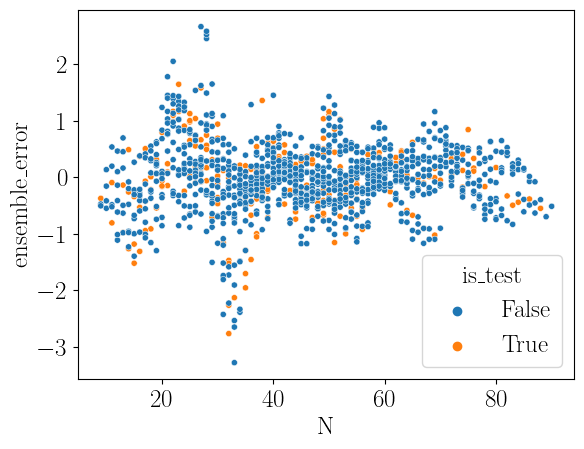

In [77]:
rmse, mae = np.sqrt(np.mean(full_exp_df.query("is_test==1")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==1")["ensemble_error"]))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, s=20, hue="is_test")

RMSE: 0.575, MAE: 0.425


In [78]:
trmse, tmae = np.sqrt(np.mean(full_exp_df.query("is_test==0")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==0")["ensemble_error"]))
print(f"RMSE: {trmse:.3f}, MAE: {tmae:.3f}")

RMSE: 0.607, MAE: 0.443


In [79]:
base_mae = 0.548867
relative_improvement = (base_mae - mae) / base_mae
relative_improvement

0.14698081102425894

# Neutron Separation energies

In [80]:
sep_df = full_exp_df.copy().query("Z>=12")

In [81]:
def predict_sn(Z, N, model):
    model_up = model(Z, N+1)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_sn(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sn_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sn_exp"] = np.nan
    return df

def theory_sn(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+1)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [82]:
def ensembled_sn(Z, N, models=models):
    # take two models of models and compute the sn
    all_sn = []
    all_sn_unc = []
    for model in (models):
        sn, unc = predict_sn(Z, N, lambda Z, N: model_ensemble(Z, N, model))
        all_sn.append(sn)
        all_sn_unc.append(unc)
    mean_sn = np.mean(all_sn)

    # We now have to propagate the uncertainties
    std_sn = np.std(all_sn)
    mean_unc = np.mean(all_sn_unc)
    total_unc = np.sqrt(mean_unc**2 + std_sn**2)
    return mean_sn, total_unc

In [83]:
sep_df["exp_sn"] = experimental_sn(sep_df)["sn_exp"]
sep_df["sr_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], dz_be), axis=1)
ens_sn = sep_df.progress_apply(lambda x: ensembled_sn(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sn"] = [x[0] for x in ens_sn]
sep_df["unc_sn"] = [x[1] for x in ens_sn]

  0%|          | 0/1266 [00:00<?, ?it/s]

In [84]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sn"] = sep_df.apply(lambda x: theory_sn(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [85]:
def get_experimiental_unc_sn(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+1)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [86]:
dz_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["dz_sn"])**2))
sr_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["sr_sn"])**2))
ensm_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["ensemble_sn"])**2))
undef_1_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["UNEDF1_sn"])**2))
print(f"SR RMSE: {sr_rmse}, DZ RMSE: {dz_rmse}, Ensemble RMSE: {ensm_rmse}, UNEDF1 RMSE: {undef_1_rmse}")

SR RMSE: 1.7746556747859579, DZ RMSE: 1.699810518705291, Ensemble RMSE: 1.6947063428237117, UNEDF1 RMSE: 1.5243561344267342


In [87]:
def plot_sn_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models

    pres = [predict_sn(fixed_z, n, model_ensemble)[0] for n in range(n_min, n_max+1)]
    unc_pred = [predict_sn(fixed_z, n, model_ensemble)[1] for n in range(n_min, n_max+1)]
    predz = [predict_sn(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sn"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sn"]))

    sns.lineplot(x="N", y="exp_sn", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="+")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sn", data=foo_df, label="UNEDF1", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="lower left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


16 35


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/150462382.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


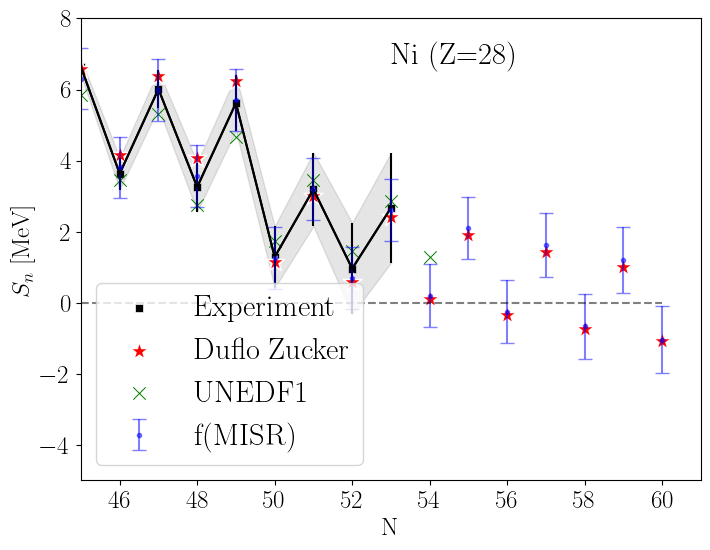

In [89]:
plot_sn_energy(28, 45, 60, "Ni (Z=28)", "sn_ni.pdf")

21 29


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/150462382.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


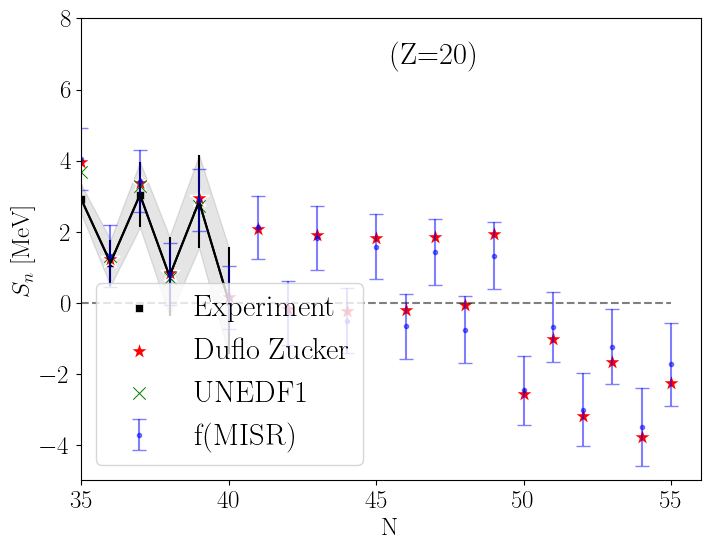

In [90]:
plot_sn_energy(20, 35, 55, "(Z=20)")

# Proton Separation energies
Now we will repeat the same process for the proton separation energies.

In [91]:
# do the same we had for the neutron separation energy but now for protons
def predict_sp(Z, N, model):
    model_up = model(Z+1, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_sp(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sp_exp"] = df[(df["Z"] == row["Z"]+1) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sp_exp"] = np.nan
    return df

def theory_sp(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+1) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [92]:
def get_experimiental_unc_sp(Z, N, df):
    try:
        return df[(df["Z"] == Z+1) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [93]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sp"] = sep_df.apply(lambda x: theory_sp(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [94]:
def ensemble_sp(Z, N, models=models):
    # take two models of models and compute the sn
    all_sp = []
    all_sp_unc = []
    for model in (models):
        sp, unc = predict_sp(Z, N, lambda Z, N: model_ensemble(Z, N, model))
        all_sp.append(sp)
        all_sp_unc.append(unc)
    mean_sp = np.mean(all_sp)

    # We now have to propagate the uncertainties
    std_sp = np.std(all_sp)
    mean_unc = np.mean(all_sp_unc)
    total_unc = np.sqrt(mean_unc**2 + std_sp**2)
    return mean_sp, total_unc

In [95]:
sep_df["exp_sp"] = experimental_sp(sep_df)["sp_exp"]
sep_df["sr_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)
ens_sp = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sp"] = [x[0] for x in ens_sp]
sep_df["unc_sp"] = [x[1] for x in ens_sp]


  0%|          | 0/1266 [00:00<?, ?it/s]

In [96]:
def plot_sp_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [predict_sp(fixed_z, n, model_ensemble)[0] for n in range(n_min, n_max+1)]
    unc_pred = [predict_sp(fixed_z, n, model_ensemble)[1] for n in range(n_min, n_max+1)]
    predz = [predict_sp(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sp"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sp"]))

    sns.lineplot(x="N", y="exp_sp", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="+")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # sns.scatterplot(x="N", y="dz_sp", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sp", data=foo_df, label="UNEDF1", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sp", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_p$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="upper left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


13 33


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/2471937114.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


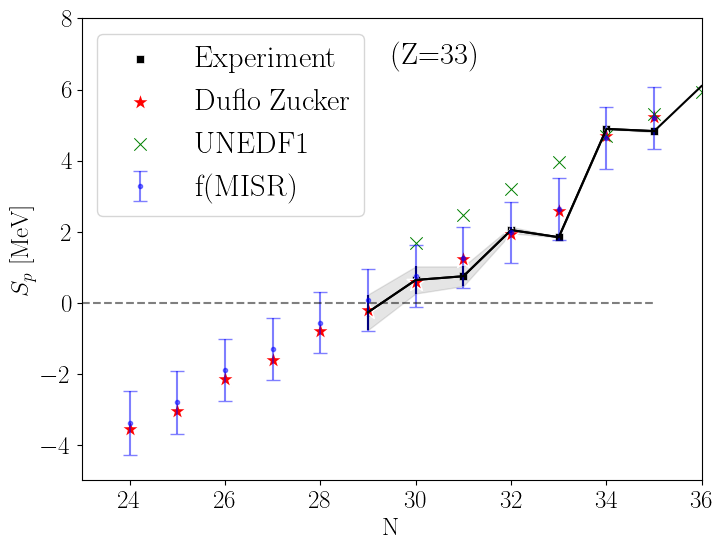

In [97]:
plot_sp_energy(33, 23, 35, "(Z=33)")

# Two neutron separation energies

In [98]:
def predict_s2n(Z, N, model):
    model_up = model(Z, N+2)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_s2n(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2n_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+2)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2n_exp"] = np.nan
    return df

def theory_s2n(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+2)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2n(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+2)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2n"] = experimental_s2n(sep_df)["s2n_exp"]
sep_df["sr_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], dz_be), axis=1)
ens_s2n = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2n"] = [x[0] for x in ens_s2n]
sep_df["unc_s2n"] = [x[1] for x in ens_s2n]

  0%|          | 0/1266 [00:00<?, ?it/s]

# Two proton separation energies

In [99]:
def predict_s2p(Z, N, model):
    model_up = model(Z+2, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_s2p(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2p_exp"] = df[(df["Z"] == row["Z"]+2) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2p_exp"] = np.nan
    return df

def theory_s2p(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+2) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2p(Z, N, df):
    try:
        return df[(df["Z"] == Z+2) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2p"] = experimental_s2p(sep_df)["s2p_exp"]
sep_df["sr_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], dz_be), axis=1)
ens_s2p = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2p"] = [x[0] for x in ens_s2p]
sep_df["unc_s2p"] = [x[1] for x in ens_s2p]


  0%|          | 0/1266 [00:00<?, ?it/s]

# Estimation of the probability of the separation energy being positive

In [100]:
import scipy.stats as stats
def probability_less_than_zero(mean, std_dev):
    # Use the CDF to find the probability that a value is less than 0
    probability = stats.norm.cdf(0, mean, std_dev)
    return probability


In [101]:
def estimate_proba_negative_sn(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    # first look on sep_df to see if the values are there precomputed
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_sn"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_sn"].values[0]
    else:
        mean, std_dev = ensembled_sn(Z, N)
    return probability_less_than_zero(mean, std_dev)

def estimate_proba_negative_sp(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    mean, std_dev = ensemble_sp(Z, N)
    # first look on sep_df to see if the values are there precomputed
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_sp"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_sp"].values[0]
    else:
        mean, std_dev = ensemble_sp(Z, N)
    return probability_less_than_zero(mean, std_dev)
def estimate_proba_negative_s2n(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_s2n"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_s2n"].values[0]
    else:
        mean, std_dev = ensembled_sn(Z, N)
    return probability_less_than_zero(mean, std_dev)
def estimate_proba_negative_s2p(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_s2p"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_s2p"].values[0]
    else:
        mean, std_dev = ensemble_sp(Z, N)
    return probability_less_than_zero(mean, std_dev)

In [102]:
def estimate_proba_bound(Z, N):
    # Estimate the probability of negative separation energies
    proba_negative_sn = estimate_proba_negative_sn(Z, N)
    proba_negative_sp = estimate_proba_negative_sp(Z, N)
    proba_negative_s2n = estimate_proba_negative_s2n(Z, N)
    proba_negative_s2p = estimate_proba_negative_s2p(Z, N)

    # Calculate the probability of positive separation energies
    proba_positive_sn = 1 - proba_negative_sn
    proba_positive_sp = 1 - proba_negative_sp
    proba_positive_s2n = 1 - proba_negative_s2n
    proba_positive_s2p = 1 - proba_negative_s2p

    # Calculate the total probability of the nucleus being bound
    # Assuming the separation energies are independent
    P_bound = proba_positive_sn * proba_positive_sp * proba_positive_s2n * proba_positive_s2p

    return P_bound


In [103]:
def find_experimental_driplines(df=sep_df):
    # Find the experimental dripline
    exp_sn = df["exp_sn"].values
    exp_sp = df["exp_sp"].values
    exp_s2n = df["exp_s2n"].values
    exp_s2p = df["exp_s2p"].values
    # Find the indices of the bound nuclei
    bound_indices = np.where((exp_sn > 0) & (exp_sp > 0) & (exp_s2n > 0) & (exp_s2p > 0))[0]
    # all the non bound nuclei are the dripline
    dripline_indices = np.where((exp_sn < 0) | (exp_sp < 0) | (exp_s2n < 0) | (exp_s2p < 0))[0]
    return bound_indices, dripline_indices

In [104]:
bound_indices, dripline_indices = find_experimental_driplines()

In [105]:
dripline_indices

array([   1,    3,   21,   43,   65,   73,   75,   82,   86,   87,  118,
        142,  152,  154,  161,  186,  205,  210,  215,  231,  251,  256,
        257,  269,  306,  307,  341,  342,  353,  359,  367,  388,  397,
        413,  424,  431,  461,  466,  472,  481,  483,  504,  522,  548,
        549,  551,  553,  557,  560,  602,  622,  634,  649,  654,  671,
        673,  677,  695,  703,  712,  726,  736,  737,  768,  780,  794,
        802,  804,  824,  827,  867,  871,  892,  896,  901,  907,  909,
        920,  940,  948,  963,  964,  977,  986, 1005, 1018, 1021, 1030,
       1045, 1080, 1086, 1100, 1101, 1122, 1125, 1128, 1132, 1167, 1170,
       1209, 1239])

In [106]:
dripline_z_n = [(z, n) for z, n in zip(sep_df.query("Z>=12 and Z<=50")["Z"].values[dripline_indices], sep_df.query("Z>=12 and Z<=50")["N"].values[dripline_indices])]

In [107]:
estimate_proba_bound(17, 13)

0.4644722082303398

In [130]:
predict_sp(17, 13, model_ensemble), predict_sp(17, 12, model_ensemble)

((0.6439972539805581, 0.8690548631365324),
 (-0.15976792457246347, 0.8723605307445378))

In [131]:
estimate_proba_negative_sp(17, 13)

0.22556213737822

In [108]:
Z_range = np.arange(13, 45)  # Proton number from 12 to 50 inclusive
N_range = np.arange(10, 60)

In [109]:
if True:
    # Define the ranges for Z and N
    Z_range = np.arange(13, 45)  # Proton number from 12 to 50 inclusive
    N_range = np.arange(10, 60)  # Neutron number up to 150 for demonstration

    # Initialize a matrix to hold the probabilities
    all_bound_matrix = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_sn = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_sp = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_s2n = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_s2p = np.full((len(Z_range), len(N_range)), np.inf)

    # Calculate the probabilities for the grid of (Z,N) values
    for i, Z in enumerate(tqdm(Z_range)):
        for j, N in enumerate(N_range):
            try:
                all_bound_matrix[i, j] = estimate_proba_bound(Z, N)
            except Exception as e:
                all_bound_matrix[i, j] = 0.
            # try:
            #     # neutron separation energy
            #     proba_matrix_sn[i, j] = estimate_proba_negative_sn(Z, N)
            # except Exception as e:
            #     proba_matrix_sn[i, j] = 0.
            # try:
            #     # proton separation energy
            #     proba_matrix_sp[i, j] = estimate_proba_negative_sp(Z, N)
            # except Exception as e:
            #     proba_matrix_sp[i, j] = 0.
            # try:
            #     # two neutron separation energy
            #     proba_matrix_s2n[i, j] = estimate_proba_negative_s2n(Z, N)
            # except Exception as e:
            #     proba_matrix_s2n[i, j] = 0.
            # try:
            #     # two proton separation energy
            #     proba_matrix_s2p[i, j] = estimate_proba_negative_s2p(Z, N)
            # except Exception as e:
            #     proba_matrix_s2p[i, j] = 0.


  0%|          | 0/32 [00:00<?, ?it/s]

In [110]:
# all_bound_matrix = (1-proba_matrix_sn) * (1-proba_matrix_sp) * (1-proba_matrix_s2n) * (1-proba_matrix_s2p)

In [111]:
len(N_range),len(Z_range), all_bound_matrix.shape

(50, 32, (32, 50))

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nuclear_chart(proba_matrix = all_bound_matrix, title='Nuclear Stability Chart', ax=None):
    #sn_matrix=None, sp_matrix=None, s2n_matrix=None, s2p_matrix=None, dripline_z_n=dripline_z_n):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
    # Replace all the 0.0 values with np.nan
    proba_matrix = np.where(proba_matrix == 0.000, np.nan, proba_matrix)
    ax.set_facecolor('white')

    cmap = plt.cm.get_cmap('RdYlBu_r').reversed()

    # Create a meshgrid for the pcolormesh function
    x, y = np.meshgrid(N_range, Z_range)


    # Use pcolormesh instead of imshow
    chart = ax.pcolormesh(x, y, proba_matrix, cmap=cmap, alpha=0.75, linewidth=0.5, edgecolor='white')

    # Draw a contour line where the probability is 0.5
    levels = [0.5]
    ct = ax.contour(N_range, Z_range, proba_matrix, levels, colors='k', linewidths=0.5)
    ax.clabel(ct, fmt='%2.1f', colors='black', fontsize=8)

    # remove the values in dripline_z_n list where the probability is very high from the drip line
    dripline_z_n = sep_df.iloc[dripline_indices][["Z", "N"]].values
    dripline_z_n = np.array([x for x in dripline_z_n if (estimate_proba_bound(x[0], x[1]) < 0.99 and Z <= 45 and N <= 80)])
    ax.scatter(dripline_z_n[:, 1], dripline_z_n[:, 0], color='black', s=10, label='Confirmed\n Unbound Nuclei')
    ax.legend(fontsize=20)

    cbar = plt.colorbar(chart, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('$P_{bound}$', rotation=270, labelpad=15)
    # ax.invert_yaxis()
    ax.set_ylim(12, 45)
    ax.set_xlabel('Neutron number N')
    ax.set_ylabel('Proton number Z')
    ax.set_title(title)
    ax.grid(True, color='black', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/3932296867.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r').reversed()


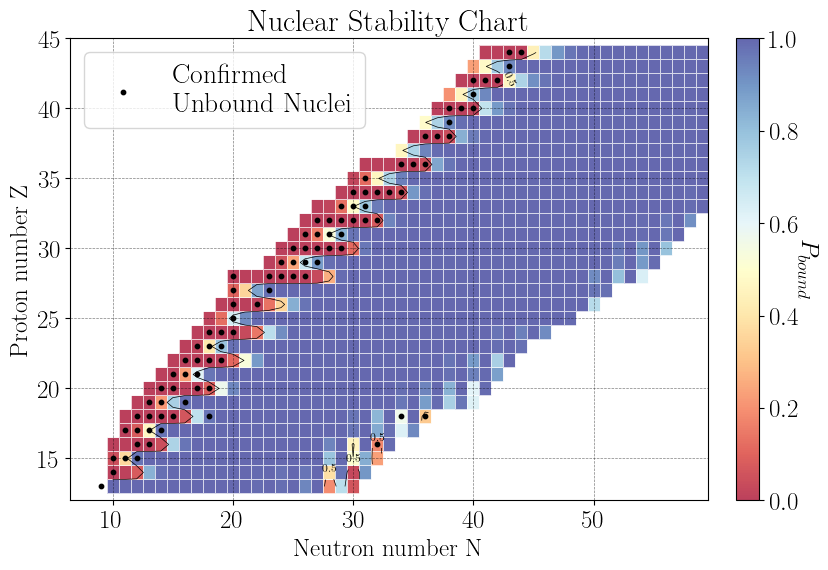

In [118]:

# Plot the probability matrix with the improved styling function
plot_nuclear_chart( all_bound_matrix)

# Error analyisis

In [119]:
probabilities_sp = [estimate_proba_bound(z, n) for z, n in tqdm(dripline_z_n)]


  0%|          | 0/101 [00:00<?, ?it/s]

In [120]:
def predict_bound_single_model(Z, N, model):
    # Get the mean and standard deviation of the ensemble of models
    sp_pred = predict_sp(Z, N, model)
    sn_pred = predict_sn(Z, N, model)
    s2n_pred = predict_s2n(Z, N, model)
    s2p_pred = predict_s2p(Z, N, model)
    # Calculate the probability of the nucleus being bound
    return (sp_pred > 0) and (sn_pred > 0) and (s2n_pred > 0) and (s2p_pred > 0)

In [121]:
# this is, the probability of being bound is greater than 0.5 (predict bounded)
predictions_bound_ens = [estimate_proba_bound(z, n)>0.5 for z, n in tqdm(dripline_z_n)]

  0%|          | 0/101 [00:00<?, ?it/s]

In [122]:
predictions_bound_dz = [predict_bound_single_model(z, n, dz_be) for z, n in tqdm(dripline_z_n)]
predicstions_bound_sr = [predict_bound_single_model(z, n, sr_be) for z, n in tqdm(dripline_z_n)]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [123]:
# we need to check where the predictions are different between ensemble and dz
predictions_bound_ens = np.array(predictions_bound_ens)
predictions_bound_dz = np.array(predictions_bound_dz)

different_predictions = np.where(predictions_bound_ens != predictions_bound_dz)[0]
z_n_differences = np.array([(z, n) for z, n in dripline_z_n])[different_predictions]

In [124]:
errors_dz = []
errors_sr = []
errors_ensemble = []
# for each one of the differences, check if the experimental value is bound or not
for z, n in tqdm(exp_df[["Z", "N"]].values):
    # print(f"Z={z}, N={n}, Ensemble: {estimate_proba_bound(z, n)}, DZ: {predict_bound_single_model(z, n, dz_be)}, SR: {predict_bound_single_model(z, n, sr_be)}")
    # Check the experiment... if it is bound or not
    exp_sp = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_sp"].values
    exp_sn = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_sn"].values
    exp_s2n = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_s2n"].values
    exp_s2p = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_s2p"].values
    is_bound = (exp_sp > 0) and (exp_sn > 0) and (exp_s2n > 0) and (exp_s2p > 0)
    prediction_bound_ensemble = estimate_proba_bound(z, n) > 0.5
    prediction_sr = predict_bound_single_model(z, n, sr_be)
    prediction_dz = predict_bound_single_model(z, n, dz_be)
    # check for errors
    if (is_bound and not prediction_sr) or (not is_bound and prediction_sr):
        errors_dz.append((z, n))
    if (is_bound and not prediction_dz) or (not is_bound and prediction_dz):
        errors_sr.append((z, n))
    if (is_bound and not prediction_bound_ensemble) or (not is_bound and prediction_bound_ensemble):
        errors_ensemble.append((z, n))

  0%|          | 0/1249 [00:00<?, ?it/s]

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/3858686965.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  is_bound = (exp_sp > 0) and (exp_sn > 0) and (exp_s2n > 0) and (exp_s2p > 0)
/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/3858686965.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (is_bound and not prediction_sr) or (not is_bound and prediction_sr):
/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_93267/3858686965.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (is_bound and not prediction_dz

In [126]:
len(errors_dz), len(errors_sr), len(errors_ensemble)

(154, 150, 179)

In [ ]:
all_last_possitive = []
for z in exp_df.Z.unique():
